**MODEL is trained on the DATASET collected as on 20th FEB 2024 on 33 services involved in Email**


File: services33_shuffled_dataset.pkl

**LOADING FILE FOR THE INFERENCE**

In [ ]:
import pandas as pd
from tqdm import tqdm
import re
import numpy as np
import string
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
df = pd.read_csv("testfile1.csv")

In [ ]:
nlogs = df.shape[0]

In [ ]:
# Adding labels to the data
label=[]
for i in range(nlogs):
    if(df['Status'][i]=='info' or df['Status'][i]=='warn' or df['Status'][i]=='ok'):
        label.append(0)
    elif(df['Status'][i]=='error' or df['Status'][i]=='emergency'):
        label.append(1)

df['Label'] =  label

In [ ]:
def remove_strings(big_string, strings_to_remove):
    for string in strings_to_remove:
        big_string = big_string.replace(string, '')
    return big_string

In [ ]:
def clean(s):
    s = re.sub('\]|\[|\)|\(|\=|\,|\;', ' ', s)
    s = " ".join([word.lower() if word.isupper() else word for word in s.strip().split()])
    s = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', s))
    s = " ".join([word for word in s.split() if not bool(re.search(r'\d', word))])
    trantab = str.maketrans(dict.fromkeys(list(string.punctuation)))
    content = s.translate(trantab)
    s = " ".join([word.lower().strip() for word in content.strip().split()])
    strings_to_remove = ['wildcard', 'yyyy', 'mmdd', 'hhmmss', 'sss']  # These words create a sense for the incorrect predictions [wildcard, yyyy, mmdd, hhmmss, sss]
    result = remove_strings(s , strings_to_remove)

    return result

**ENCODING THE MESSAGES**

In [ ]:
from transformers import GPT2Tokenizer, TFGPT2Model
from transformers import BertTokenizer, TFBertModel
from transformers import RobertaTokenizer, TFRobertaModel

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
def bert_encoder(s, no_wordpiece=0):
    """ Compute semantic vector with BERT
    Parameters
    ----------
    s: string to encode
    no_wordpiece: 1 if you do not use sub-word tokenization, otherwise 0

    Returns
    -------
        np array in shape of (768,)
    """
    if no_wordpiece:
        words = s.split(" ")
        words = [word for word in words if word in bert_tokenizer.vocab.keys()]
        s = " ".join(words)
    inputs = bert_tokenizer(s, return_tensors='tf', max_length=512)
    outputs = bert_model(inputs)
    v = tf.reduce_mean(outputs.last_hidden_state, 1)
    return v[0]

In [ ]:
encoded=[]
for i in tqdm(range(nlogs)):
    cleaned_msg = clean(df["Message"][i])
    encoded_msg = bert_encoder(cleaned_msg)
    encoded.append(encoded_msg)


100%|██████████| 300/300 [01:13<00:00,  4.10it/s]


In [ ]:
df["Encoded"] = encoded

In [ ]:
df.head()

,Count,Status,Service,Message,Label,Encoded
0,≈320K,info,ix-virtual-load-tester,"[Accepting [wildcard]*[/wildcard] interaction,...",0,"(tf.Tensor(-0.27009603, shape=(), dtype=float3..."
1,≈320K,info,ix-virtual-load-tester,"[Delete interactionID: [wildcard]*[/wildcard],...",0,"(tf.Tensor(0.12268964, shape=(), dtype=float32..."
2,≈250K,info,ix-virtual-load-tester,[New interaction. State: ALERTING. Transfer ty...,0,"(tf.Tensor(-0.2297304, shape=(), dtype=float32..."
3,≈250K,info,user-service,"AccountId [wildcard]*[/wildcard], waiting for ...",0,"(tf.Tensor(0.08132772, shape=(), dtype=float32..."
4,≈230K,info,vrc-availability-service,"messageReceived, received [wildcard]*[/wildcar...",0,"(tf.Tensor(0.03244999, shape=(), dtype=float32..."


In [ ]:
embed_dim = 768  # Embedding size for each token
num_heads = 12  # Number of attention heads
ff_dim = 2048  # Hidden layer size in feed forward network inside transformer
max_len = 75
num_layers = 1

In [ ]:
class BatchGenerator(Sequence):

    def __init__(self, X, batch_size):
        self.X = X
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.X) / float(self.batch_size)))

    def __getitem__(self, idx):

        dummy = np.zeros(shape=(embed_dim,))
        x = self.X[idx * self.batch_size:min((idx + 1) * self.batch_size, len(self.X))]
        X = np.zeros((len(x), max_len, embed_dim))
        item_count = 0

        for i in range(idx * self.batch_size, min((idx + 1) * self.batch_size, len(self.X))):
            x = self.X[i]
            if len(x) > max_len:
                x = x[-max_len:]

            desired_shape = (75, 768)
            x=tf.expand_dims(x,axis=1)
            x=tf.tile(x, [1, desired_shape[1]])
            x = np.pad(np.array(x), pad_width=((max_len - len(x), 0), (0, 0)), mode='constant',
                       constant_values=0)

            X[item_count] = np.reshape(x, [max_len, embed_dim])
            item_count += 1

        return X[:]

**CUSTOM OBJECTS (FUNCTIONS) FOR LOADING THE MODEL**

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim,trainable=True,dtype='float32',rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=True):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
class PositionEmbedding(layers.Layer):
    def __init__(self, max_len, vocab_size, embed_dim, trainable=True,dtype='float32'):
        super(PositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)

        self.pos_encoding = positional_encoding(max_len,
                                                embed_dim)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        x += self.pos_encoding[:, :seq_len, :]
        return x

In [ ]:
#Load the model
model = keras.models.load_model(
    'tenth_model.keras',
    custom_objects={
        'PositionEmbedding': PositionEmbedding,
        'TransformerBlock': TransformerBlock
    }
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:357: UserWarning: `build()` was called on layer 'position_embedding_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:357: UserWarning: `build()` was called on layer 'transformer_block_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [ ]:
def test_model(model, x, batch_size):
    test_loader = BatchGenerator(x, batch_size=batch_size)
    prediction = model.predict(test_loader,
                                         steps=len(x) // batch_size,
                                         verbose=1)
    prediction = np.argmax(prediction, axis=1)
    return prediction

In [ ]:
prediction_array = test_model(model, df["Encoded"], 30)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step


In [ ]:
print(df["Encoded"], prediction_array)

0      (tf.Tensor(-0.27009603, shape=(), dtype=float3...
1      (tf.Tensor(0.12268964, shape=(), dtype=float32...
2      (tf.Tensor(-0.2297304, shape=(), dtype=float32...
3      (tf.Tensor(0.08132772, shape=(), dtype=float32...
4      (tf.Tensor(0.03244999, shape=(), dtype=float32...
                             ...                        
295    (tf.Tensor(0.053640146, shape=(), dtype=float3...
296    (tf.Tensor(-0.21823448, shape=(), dtype=float3...
297    (tf.Tensor(0.04900824, shape=(), dtype=float32...
298    (tf.Tensor(-0.1303999, shape=(), dtype=float32...
299    (tf.Tensor(-0.04900688, shape=(), dtype=float3...
Name: Encoded, Length: 300, dtype: object [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 

In [ ]:
corr_incorr_pred=[]
for i in range(nlogs):
    if(prediction_array[i] == label[i]):
        corr_incorr_pred.append(1)
    else:
        corr_incorr_pred.append(0)


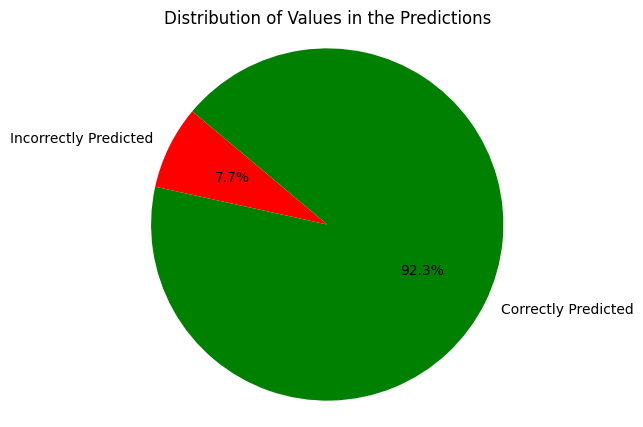

In [ ]:
import matplotlib.pyplot as plt
def analyze_array(array):
    # Count the occurrences of 0s and 1s in the array
    count_zeros = array.count(0)
    count_ones = array.count(1)

    # Labels for the pie chart
    labels = ['Incorrectly Predicted', 'Correctly Predicted']

    # Data to plot
    sizes = [count_zeros, count_ones]

    # Colors
    colors = ['red', 'green']

    # Plot
    plt.figure(figsize=(5,5))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Distribution of Values in the Predictions')
    plt.show()

analyze_array(corr_incorr_pred)

**CONFUSION MATRIX**

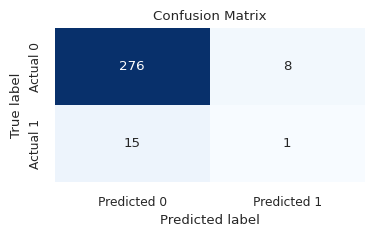

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(label ,prediction_array)

# Plot confusion matrix using Seaborn
sns.set(font_scale=0.8)  # Adjust to fit your needs
plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()
